<a href="https://colab.research.google.com/github/abrham17/ML_Pytorch_repo/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import transforms, datasets
import numpy as np
from sklearn.decomposition import PCA
import time
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
all_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2023, 0.1994, 0.2010])
])
train_set = datasets.CIFAR100(root='./data', train=True, download=True, transform=all_transforms)
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)


100%|██████████| 169M/169M [00:03<00:00, 45.6MB/s]


In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(4096, 256),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        features = self.fc(x)
        return features


In [5]:
feature_extractor = FeatureExtractor().to(device)
feature_extractor


FeatureExtractor(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
  )
)

In [7]:
all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        features = feature_extractor(images)
        all_features.append(features.to(device).numpy())
        all_labels.append(labels.to(device).numpy())


In [8]:
all_features = np.concatenate(all_features, axis=0)  #(50000 , 256)
all_labels = np.concatenate(all_labels, axis=0)

In [9]:
all_features.shape


(50000, 256)

In [10]:
n_components = 50
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(all_features)


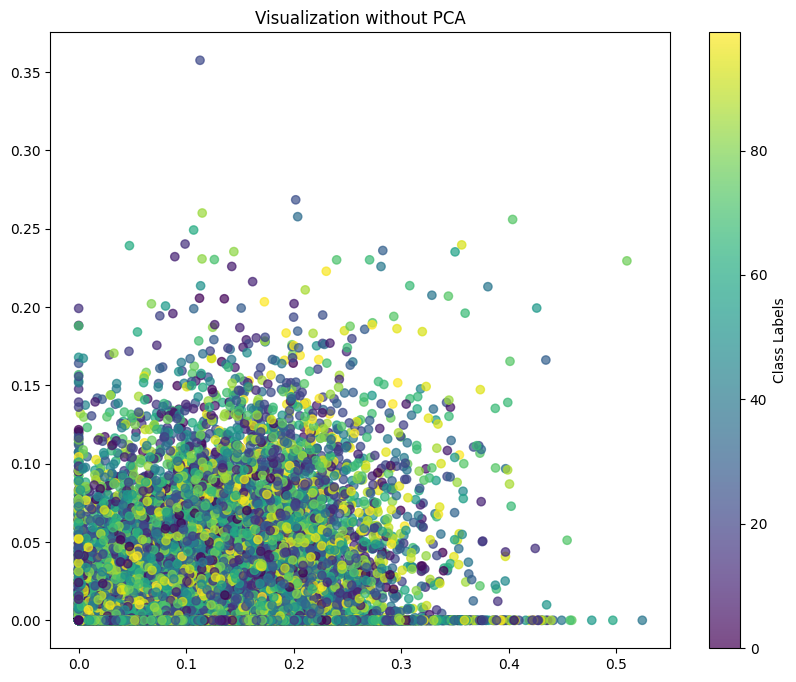

In [13]:

plt.figure(figsize=(10, 8))
scatter = plt.scatter(all_features[:, 1], all_features[:, 2], c=all_labels, cmap='viridis', alpha=0.7)
plt.title("Visualization without PCA")
plt.colorbar(scatter, label='Class Labels')
plt.show()


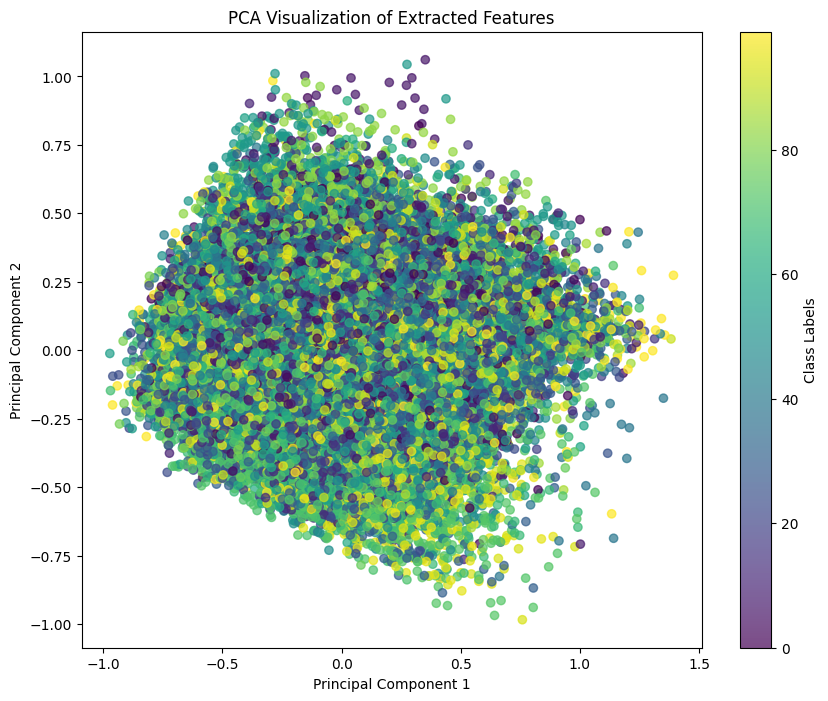

In [15]:

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_features[:, 1], pca_features[:, 2], c=all_labels, cmap='viridis', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Extracted Features")
plt.colorbar(scatter, label='Class Labels')
plt.show()


In [24]:
features_tensor = torch.tensor(all_features, dtype=torch.float32)
pca_features_tensor = torch.tensor(pca_features, dtype=torch.float32)
labels_tensor = torch.tensor(all_labels, dtype=torch.long)

dataset_original = TensorDataset(features_tensor, labels_tensor)
dataset_pca = TensorDataset(pca_features_tensor, labels_tensor)

loader_original = DataLoader(dataset_original, batch_size=64, shuffle=True)
loader_pca = DataLoader(dataset_pca, batch_size=64, shuffle=True)


In [25]:
print(features_tensor.shape)
print(pca_features_tensor.shape)

torch.Size([50000, 256])
torch.Size([50000, 50])


In [35]:
class SimpleImageClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=100):
        super(SimpleImageClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, 300)
        self.fc2 = nn.Linear(300, num_classes)

    def forward(self, x):
        return self.fc2(self.fc(x))

In [37]:
num_classes = 100

model_original = SimpleImageClassifier(input_dim=256, num_classes=num_classes).to(device)
model_pca = SimpleImageClassifier(input_dim=n_components, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_orig = optim.Adam(model_original.parameters(), lr=0.01)
optimizer_pca = optim.Adam(model_pca.parameters(), lr=0.01)


In [39]:
def train_classifier(model, optimizer, dataloader, num_epochs=10):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        for batch_features, batch_labels in dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_features.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

        epoch_loss /= total
        acc = correct / total * 100
        losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Accuracy: {acc:.2f}%")
    return losses


In [40]:
print("\nTraining classifier on original (256-dim) features:")
start_time = time.time()
losses_orig = train_classifier(model_original, optimizer_orig, loader_original, num_epochs=32)
print("Training time (original features):", time.time() - start_time, "seconds\n")

print("Training classifier on PCA-reduced (50-dim) features:")
start_time = time.time()
losses_pca = train_classifier(model_pca, optimizer_pca, loader_pca, num_epochs=32)
print("Training time (PCA features):", time.time() - start_time, "seconds")



Training classifier on original (256-dim) features:
Epoch [1/32] Loss: 3.8207 Accuracy: 13.18%
Epoch [2/32] Loss: 3.6202 Accuracy: 16.70%
Epoch [3/32] Loss: 3.5790 Accuracy: 17.88%
Epoch [4/32] Loss: 3.5389 Accuracy: 18.46%
Epoch [5/32] Loss: 3.5173 Accuracy: 19.15%
Epoch [6/32] Loss: 3.5042 Accuracy: 19.08%
Epoch [7/32] Loss: 3.4893 Accuracy: 19.46%
Epoch [8/32] Loss: 3.4787 Accuracy: 19.64%
Epoch [9/32] Loss: 3.4611 Accuracy: 19.97%
Epoch [10/32] Loss: 3.4576 Accuracy: 20.09%
Epoch [11/32] Loss: 3.4408 Accuracy: 20.27%
Epoch [12/32] Loss: 3.4392 Accuracy: 20.37%
Epoch [13/32] Loss: 3.4261 Accuracy: 20.51%
Epoch [14/32] Loss: 3.4260 Accuracy: 20.49%
Epoch [15/32] Loss: 3.4217 Accuracy: 20.82%
Epoch [16/32] Loss: 3.4172 Accuracy: 20.85%
Epoch [17/32] Loss: 3.4105 Accuracy: 20.76%
Epoch [18/32] Loss: 3.4050 Accuracy: 20.93%
Epoch [19/32] Loss: 3.3969 Accuracy: 20.99%
Epoch [20/32] Loss: 3.3974 Accuracy: 21.18%
Epoch [21/32] Loss: 3.3999 Accuracy: 21.12%
Epoch [22/32] Loss: 3.3955 Accur

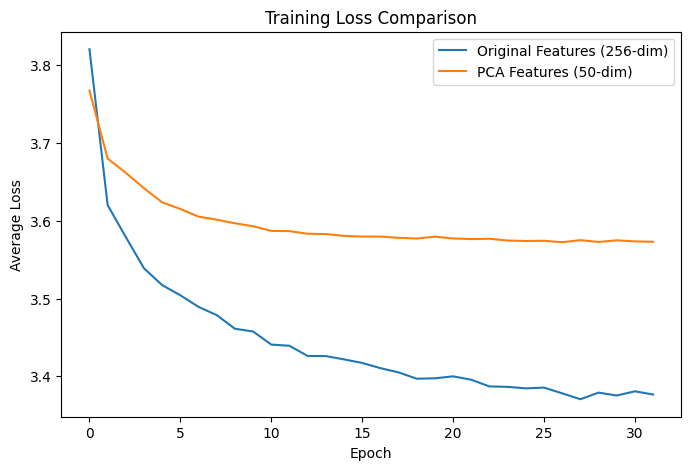

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(losses_orig, label="Original Features (256-dim)")
plt.plot(losses_pca, label="PCA Features (50-dim)")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()
